In [61]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [62]:
df = pd.read_csv("Data/vixcurrent.csv",skiprows=1)

In [63]:
df.head()

,Date,VIX Open,VIX High,VIX Low,VIX Close
0,1/2/2004,17.96,18.68,17.54,18.22
1,1/5/2004,18.45,18.49,17.44,17.49
2,1/6/2004,17.66,17.67,16.19,16.73
3,1/7/2004,16.72,16.75,15.50,15.50
4,1/8/2004,15.42,15.68,15.32,15.61


In [64]:
df.drop(['VIX Open', 'VIX High', 'VIX Low'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df.head(10)

,VIX Close
Date,
2004-01-02,18.22
2004-01-05,17.49
2004-01-06,16.73
2004-01-07,15.50
2004-01-08,15.61
2004-01-09,16.75
2004-01-12,16.82
2004-01-13,18.04
2004-01-14,16.75


In [15]:
df.rename(columns={'VIX Close':'Adj Close'}, inplace=True)
df.head()

,Adj Close
Date,
2004-01-02,18.22
2004-01-05,17.49
2004-01-06,16.73
2004-01-07,15.50
2004-01-08,15.61


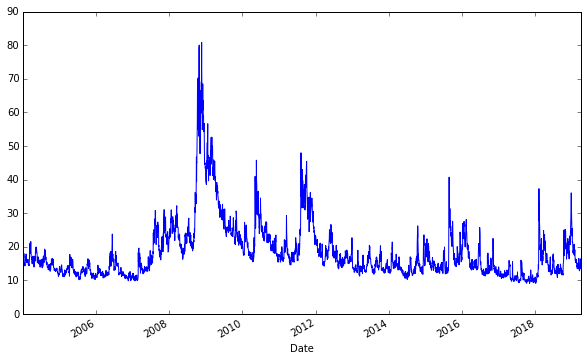

In [16]:
plt.figure(figsize=(10, 6))
df['Adj Close'].plot()

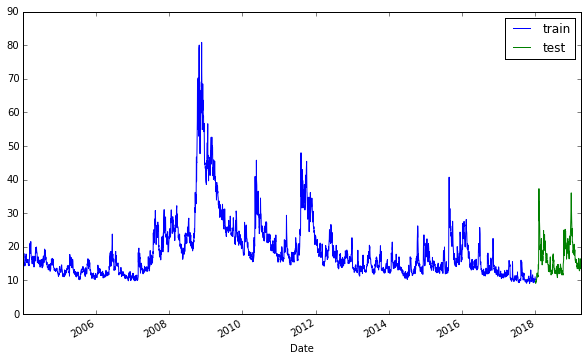

In [17]:
split_date = pd.Timestamp('2018-01-01')
df =  df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [23]:
df

Date
2004-01-02    18.22
2004-01-05    17.49
2004-01-06    16.73
2004-01-07    15.50
2004-01-08    15.61
2004-01-09    16.75
2004-01-12    16.82
2004-01-13    18.04
2004-01-14    16.75
2004-01-15    15.56
2004-01-16    15.00
2004-01-20    15.21
2004-01-21    14.34
2004-01-22    14.71
2004-01-23    14.84
2004-01-26    14.55
2004-01-27    15.35
2004-01-28    16.78
2004-01-29    17.14
2004-01-30    16.63
2004-02-02    17.11
2004-02-03    17.34
2004-02-04    17.87
2004-02-05    17.71
2004-02-06    16.00
2004-02-09    16.39
2004-02-10    15.94
2004-02-11    15.39
2004-02-12    15.31
2004-02-13    15.58
              ...  
2019-02-15    14.91
2019-02-19    14.88
2019-02-20    14.02
2019-02-21    14.46
2019-02-22    13.51
2019-02-25    14.85
2019-02-26    15.17
2019-02-27    14.70
2019-02-28    14.78
2019-03-01    13.57
2019-03-04    14.63
2019-03-05    14.74
2019-03-06    15.74
2019-03-07    16.59
2019-03-08    16.05
2019-03-11    14.33
2019-03-12    13.77
2019-03-13    13.41
2019-03-14    1

In [40]:
scaler = MinMaxScaler(feature_range=(-1, 1))
new_train = train.as_matrix().reshape(-1, 1)
train_sc = scaler.fit_transform(new_train)
test_sc = scaler.transform(test.as_matrix().reshape(-1, 1))

/Users/tunjiogunbiyi/anaconda/envs/rnnlm/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/tunjiogunbiyi/anaconda/envs/rnnlm/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [41]:
X_train = train_sc[:-1]
y_train = train_sc[1:]
X_test = test_sc[:-1]
y_test = test_sc[1:]

In [42]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
3523/3523 [==============================] - 4s 1ms/step - loss: 0.0392
Epoch 2/100
3523/3523 [==============================] - 4s 998us/step - loss: 0.0025
Epoch 3/100
3523/3523 [==============================] - 4s 1ms/step - loss: 0.0026
Epoch 4/100
3523/3523 [==============================] - 4s 1ms/step - loss: 0.0026
Epoch 00004: early stopping


In [43]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.872
The R2 score on the Test set is:	0.612


In [50]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

('Train shape: ', (3523, 1, 1))
('Test shape: ', (311, 1, 1))


/Users/tunjiogunbiyi/anaconda/envs/rnnlm/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/tunjiogunbiyi/anaconda/envs/rnnlm/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/tunjiogunbiyi/anaconda/envs/rnnlm/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/tunjiogunbiyi/anaconda/envs/rnnlm/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [72]:
X_train.shape[1]

1

In [56]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
3523/3523 [==============================] - 10s 3ms/step - loss: 0.0153
Epoch 2/100
3523/3523 [==============================] - 9s 3ms/step - loss: 0.0024
Epoch 3/100
3523/3523 [==============================] - 10s 3ms/step - loss: 0.0024
Epoch 4/100
3523/3523 [==============================] - 10s 3ms/step - loss: 0.0024
Epoch 5/100
3523/3523 [==============================] - 10s 3ms/step - loss: 0.0023
Epoch 6/100
3523/3523 [==============================] - 10s 3ms/step - loss: 0.0023
Epoch 7/100
3523/3523 [==============================] - 9s 3ms/step - loss: 0.0023
Epoch 8/100
3523/3523 [==============================] - 9s 3ms/step - loss: 0.0023
Epoch 9/100
3523/3523 [==============================] - 10s 3ms/step - loss: 0.0023
Epoch 10/100
3523/3523 [==============================] - 10s 3ms/step - loss: 0.0023
Epoch 11/100
3523/3523 [==============================] - 10s 3ms/step - loss: 0.0023
Epoch 12/100
3523/3523 [==============================] - 10s 3ms/

In [57]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.937
The R2 score on the Test set is:	0.784


In [58]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

311/311 [==============================] - 0s 1ms/step
NN: 0.006653
LSTM: 0.003704


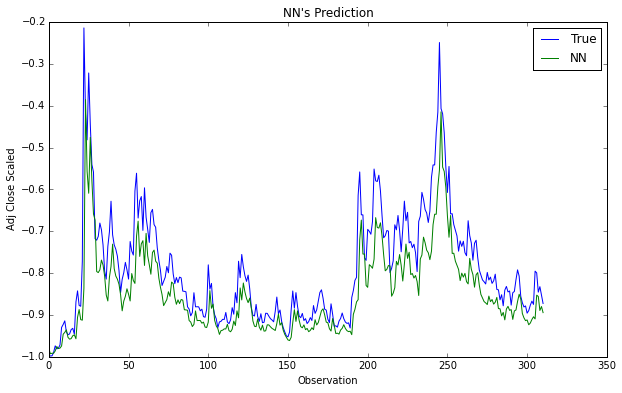

In [59]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("NN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

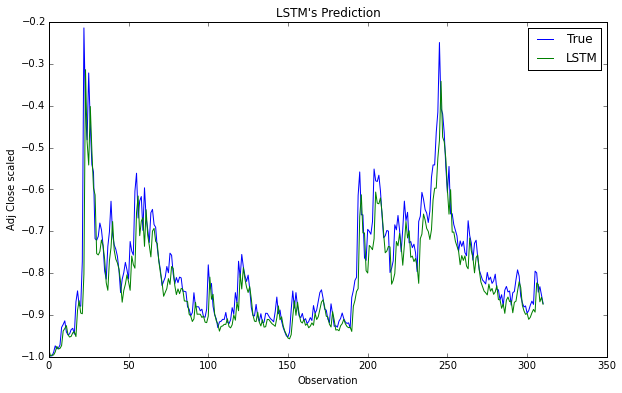

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();


# Extension with 1D-CNN

In [67]:
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils